
# 2D Helmholtz PINN with SIREN

This notebook implements a simple **physics-informed neural network (PINN)** to solve the 2D scalar Helmholtz equation for the out-of-plane field $E_z(x, y)$.
We parameterize the complex field as two real-valued outputs, $Re(E_z)$ and $Im(E_z)$, from a **SIREN** network (sine-activated MLP).

**PDE:**
$$
-\nabla^2 E_z(x,y) - \varepsilon(x,y)\,\omega^2\,E_z(x,y) \;=\; -i\,\omega\,J_z(x,y).
$$

- The source $J_z$ is approximated as a **single-point** injection at the grid point closest to `source_position`.
- Relative permittivity $\varepsilon$ can be uniform (free space) or have a circular dielectric inclusion.
- We enforce a simple **Sommerfeld-like absorbing condition** on a thin strip at the domain boundaries:
$$
\frac{\partial E_z}{\partial n} + i\,\omega\,E_z = 0.
$$

**What’s in here:**
- A documented SIREN implementation (`SineLayer`, `SIREN`).
- A documented solver class (`HelmholtzSolver`) with:
  - grid creation
  - Laplacian via autodiff
  - PDE residual and boundary loss
  - training loop with optional LR scheduler
  - prediction and visualization
- Three example experiments (free-space, small circle dielectric in the corner, and large circle dielectric in the center configurations).

# Report: 2D Helmholtz PINN with SIREN

## Problem statement

We solve the scalar 2D Helmholtz equation for the out-of-plane field $E_z(x,y)$:
$$
-\nabla^2 E_z(x,y) - \varepsilon(x,y)\,\omega^2\,E_z(x,y) \;=\; -i\,\omega\,J_z(x,y).
$$

- $\varepsilon(x,y)$ is the **relative permittivity** (1.0 in free space; a constant $>1$ inside a circular dielectric).
- $\omega$ is the **angular frequency**.
- $J_z$ is a **point-like source**, approximated by placing unit amplitude at the grid point closest to a target position.

On the outer boundary we impose a **Sommerfeld-like absorbing condition** in a thin strip:
$$
\frac{\partial E_z}{\partial n} + i\,\omega\,E_z \approx 0.
$$

## Approach (PINN + SIREN)

We represent $E_z$ via a neural network with **sine activations** (SIREN). The network outputs two channels:
$$
\big(\operatorname{Re} E_z(x,y),\ \operatorname{Im} E_z(x,y)\big).
$$

The training loss is
$$
\mathcal{L} \;=\; \mathcal{L}_{\text{PDE}} \;+\; \mathcal{L}_{\text{BC}},
$$
where
$$
\mathcal{L}_{\text{PDE}} \;=\; \frac{1}{N}\sum_{k=1}^N
\left\|
\begin{bmatrix}
-\nabla^2 \operatorname{Re}E_z - \varepsilon\,\omega^2 \operatorname{Re}E_z - \omega\,\operatorname{Im}J_z \\[4pt]
-\nabla^2 \operatorname{Im}E_z - \varepsilon\,\omega^2 \operatorname{Im}E_z + \omega\,\operatorname{Re}J_z
\end{bmatrix}
\right\|_2^2,
$$
and the boundary loss in each side-strip is
$$
\mathcal{L}_{\text{BC}} \;=\; \frac{1}{N_{\partial\Omega}}
\sum_{\boldsymbol{x}_k\in \text{strips}}
\left[
\left(\frac{\partial\,\operatorname{Re}E_z}{\partial n} + \omega\,\operatorname{Im}E_z\right)^2
+
\left(\frac{\partial\,\operatorname{Im}E_z}{\partial n} - \omega\,\operatorname{Re}E_z\right)^2
\right].
$$

We compute all derivatives via **autodiff**. The SIREN initialization follows the original paper to stabilize training at high frequencies.

## Implementation highlights

- **Network:** SIREN with `hidden_layers=3`, `hidden_features=256` (selected after hyperparameter tuning) and frequency scale `omega_0=30`.
- **Hyperparameter search:** Tested hidden features in {64, 128, 256}, hidden layers in {2, 3, 4}, learning rates from $1\times10^{-6}$ to $5\times10^{-5}$, and $\omega_0$ values in {15, 20, 25, 30, 40}. The chosen configuration offered the best trade-off between accuracy and training time for this review.
- **Grid:** Uniform square grid of size `grid_points × grid_points` covering $[-\frac{L}{2}, \frac{L}{2}]^2$.
- **Source:** One-hot at the nearest collocation point to `source_position`.
- **Dielectric:** Optional single circular inclusion; extending to multiple circles only requires summing masks.
- **Optimizer/Schedule:** Adam with optional `ReduceLROnPlateau` for long training.
- **Hardware constraints:** No access to a CUDA-enabled GPU during the internship, so all training was done on CPU with reduced resolution and fewer iterations to fit within available computational resources.

## Experiments

We include three representative configurations:

1. **Free-space** (no dielectric).
2. **Small single dielectric** shifted at $(x_0, y_0)$ with radius $r$ and $\varepsilon>1$.
3. **Large dielectric** at the center $(x_0=0, y_0=0)$.

For each case we train for `500` epochs with `batch_size=512`.

## Results & analysis

### Convergence
Across all cases, the total and physics losses drop rapidly in the first few dozen epochs, then plateau at a problem-dependent level. Learning rate schedules show clear drops when plateaus are reached. Using a finer mesh (higher spatial resolution) could improve convergence by providing the network with more detailed spatial information, though at the cost of higher computational load. Boundary loss decays more gradually and can plateau higher for more complex geometries (e.g., with a central dielectric). If boundary loss $\mathcal{L}_{\text{BC}}$ stops decreasing, relaxing the boundary strip width or adding a cosine ramp weight can help.

### Field patterns
- **Free space:** $|E_z|$ exhibits concentric rings consistent with cylindrical waves radiating from the source. Symmetry is maintained, and phase advances uniformly outward. The behaviour of the field at the boundaries is consistent and doesn't show any extra artifacts.
- **Large dielectric in the center:** Wavefronts bend significantly inside the dielectric due to reduced phase velocity ($\varepsilon=2$). We can see that the wavelength is also reduced roughly 2 times inside the dielectric. Behind the object and on the sides, interference fringes, curvature, and mild focusing effects are visible.
- **Small dielectric in the corner:** The global wavefront structure remains nearly circular, with localized scattering and slight phase shifts confined to the object’s shadow region.
-  All of these results are consistent with the physical intuition and analytical solutions we expect for a single point source in the Helmholtz equation.

### Effect of $\omega_0$ (SIREN frequency)
Larger $\omega_0$ increases the network’s capacity to represent high-frequency features but can make optimization more challenging.
In our case, I chose $\omega_0$ slightly higher than the source frequency to ensure that all relevant spatial features could be captured.
Setting $\omega_0$ higher and using a deeper neural network can help resolve small-scale features; however, without access to a CUDA GPU, such configurations are too time-consuming to train. Nevertheless, they are worth exploring for real-world problems where fine detail is critical.

In these runs, `omega_0=30` worked robustly for `grid_points=128` and `omega=20`.

### Qualitative checks
- **Free space:** Symmetry relative to the source, radial phase advance, $|E_z|$ decay outward.
- **Dielectric cases:** Curvature and phase delay consistent with refraction, internal interference patterns visible.
- **Small scatterer:** Confined perturbations, good for testing model sensitivity to localized index changes.

## Limitations & potential improvements

- **Point source model:** The current one-point source is a rough approximation. A narrow Gaussian or analytic Green’s function source could reduce artifacts and improve convergence, but this would require significantly more computational resources.
- **Absorbing boundary:** The implemented strip penalty approximates a Sommerfeld condition. For improved performance, a perfectly matched layer or impedance-matched absorbing term could be used to better suppress reflections.
- **Multiple inclusions:** A straightforward extension of $\varepsilon(x,y)$ can be made by summing multiple shape masks to model more complex geometries. This can be easily implemented in the current code structure by modifying the `get_permittivity` method to sum up several structures.
- **Validation:** In these experiments, the wavelength is exactly determined by the parameters we define. For real-world problems, validation should include comparing results against reference solutions from numerical solvers, or against analytical solutions to quantify accuracy in both amplitude and phase.

## Reproducibility

- All main hyperparameters are collected in a single `params` dictionary for each experiment. The code is organized into modular classes, making it easy to update parameters, extend functionality (e.g., adding multiple inclusions or new boundary conditions), and reuse core components across different experiments. This modular design also ensures that changes in one part of the solver do not require rewriting other parts.
- To reproduce a figure: run the relevant solver setup, then call `plot_losses()`, `predict()`, and `visualize()` in sequence. This will regenerate both the loss curves and the field plots for the chosen configuration.


(*some extra cnclusions and results are in the end of the file after the code*)

Now let's define the **configuration parameters** for our simulation.
These parameters control every aspect of the problem setup, including:

- **Domain settings**: size of the square computational domain and grid resolution.
- **Physics parameters**: wave frequency, source position, and material properties.
- **Dielectric inclusion**: position, radius, and relative permittivity of a single circular dielectric (if enabled).
- **Neural network settings**: architecture of the SIREN model (layer width, depth, and frequency scaling `omega_0`).
- **Training settings**: number of epochs, learning rate, batch size, and print interval.
- **Scheduler settings**: parameters for adaptive learning rate reduction.

Adjusting these values allows us to switch between free-space and dielectric cases,
change the network’s complexity, and control the trade-off between training time and solution accuracy.

In [541]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from tqdm.auto import trange
# ------------------------------
# Configuration parameters
# ------------------------------
params = {
    # Domain
    'domain_size': 5.0,  # Square domain side length (units are arbitrary)
    'grid_points': 128,  # Number of samples per axis

    # Physics
    'omega': 20.0,  # Angular frequency for Helmholtz
    'source_position': (-1., -1.5),  # Point source location (approximate)

    # Dielectric (single circular inclusion)
    'has_dielectric': False,
    'dielectric_center': (0.0, -1.0),
    'dielectric_radius': 0.3,
    'dielectric_eps': 2.0,  # Relative permittivity inside the circle; outside is 1.0

    # Network (SIREN)
    'hidden_features': 256,
    'hidden_layers': 3,  # Number of hidden Sine layers (not counting the final linear layer)
    'omega_0': 30.0,  # SIREN frequency scaling

    # Training
    'num_epochs': 500,
    'learning_rate': 2e-5,
    'batch_size': 512,
    'print_every': 50,

    # Scheduler
    'use_scheduler': True,
    'scheduler_patience': 100,
    'scheduler_factor': 0.5,
    'scheduler_min_lr': 1e-9,
}

The following classes implement the **SIREN** architecture (Sitzmann et al., 2020),
a type of Multi-Layer Perceptron (MLP) that uses sine functions as activation layers.

- **`SineLayer`** defines a single fully connected layer followed by a sine nonlinearity with a tunable frequency scale (`omega_0`).
- **`SIREN`** stacks these `SineLayer` modules to form a network that maps 2D coordinates $(x, y)$ to the real and imaginary parts of $E_z$.

Physically, this network learns the continuous spatial field $E_z(x, y)$ directly from the PDE constraints,
allowing smooth interpolation across the entire domain.

In [534]:
class SineLayer(nn.Module):
    """
    A single SIREN layer: Linear -> sine activation with frequency scaling.

    Args:
        in_features (int): input dimensionality
        out_features (int): output dimensionality
        omega_0 (float): frequency scaling for sine activation
        is_first (bool): if True, use the special initialization for the first layer

    Notes:
        Weight initialization follows the SIREN paper:
        - First layer: U(-1/in_features, 1/in_features)
        - Subsequent layers: U(-sqrt(6/in_features)/omega_0, sqrt(6/in_features)/omega_0)
    """
    def __init__(self, in_features, out_features, omega_0, is_first=False):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)

        # SIREN weight initialization
        with torch.no_grad():
            if is_first:
                self.linear.weight.uniform_(-1. / in_features, 1. / in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / in_features) / omega_0, np.sqrt(6 / in_features) / omega_0)

    def forward(self, x):
        # Sine nonlinearity with the omega_0 scaling
        return torch.sin(self.omega_0 * self.linear(x))

class SIREN(nn.Module):
    """
    A SIREN Multi-Layer Perceptron that maps 2D coordinates (x, y) -> (Re(Ez), Im(Ez)).

    Args:
        in_features (int): input dimensionality (2 for x,y)
        hidden_features (int): width of hidden layers
        hidden_layers (int): number of Sine layers after the first
        out_features (int): output dimensionality (2 for real, imag)
        omega_0 (float): frequency scaling used in Sine layers
    """
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, omega_0):
        super().__init__()
        self.net = []

        # First layer (sin)
        self.net.append(SineLayer(in_features, hidden_features, omega_0, is_first=True))

        # Hidden layers (sin)
        for _ in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, omega_0, is_first=False))

        # Final linear layer (no sin)
        final_layer = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            final_layer.weight.uniform_(-np.sqrt(6 / hidden_features) / omega_0, np.sqrt(6 / hidden_features) / omega_0)
        self.net.append(final_layer)
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)

Now let's define the **`HelmholtzSolver`** class,
which will implement our physics-informed neural network (PINN) for solving the 2D scalar Helmholtz equation using a **SIREN** backbone.

This class handles:

- **Model setup** – Creates the SIREN neural network with the given architecture and hyperparameters.
- **Domain & grid creation** – Generates a uniform square grid of coordinates across the simulation domain.
- **Material properties** – Supports free-space or dielectric inclusions by assigning spatially varying permittivity values.
- **Source definition** – Approximates a point source (`Jz`) located at a user-specified position.
- **Physics calculations** –
  - Computes Laplacians using autograd.
  - Builds the PDE residual for both real and imaginary components of the field.
  - Applies an absorbing boundary condition to mimic the Sommerfeld radiation condition.
- **Training loop** – Minimizes the sum of PDE and boundary condition losses using Adam (and optionally a learning rate scheduler).
- **Visualization** – Plots the predicted field’s real part and magnitude, with optional dielectric outlines.

By placing all problem setup, physics, training, and visualization steps inside a single class,
we make the solver **modular, reusable, and easy to extend** for more complex geometries or boundary conditions.

In [535]:
class HelmholtzSolver:
    """
    Physics-Informed solver for the 2D scalar Helmholtz equation using a SIREN backbone.

    Solves for E_z such that:
        -ΔE_z - ε(x,y) * ω^2 * E_z = -i * ω * J_z

    The field is represented by two outputs of the network: (Re(E_z), Im(E_z)).
    The PDE residual and boundary condition terms form the training loss.

    Args:
        param (dict): configuration dictionary (see `params` in the beginning)

    Attributes:
        model (nn.Module): SIREN model
        device (torch.device): CPU or CUDA
        grid_points_flat (Tensor): (N,2) input coordinates over the domain
    """
    def __init__(self, param):
        # Extract parameters with defaults
        self.domain_size = param['domain_size']
        self.grid_points = param['grid_points']
        self.omega = param['omega']
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # print(f"device: {self.device}")

        # Initialize SIREN model
        self.model = SIREN(
            in_features=2,
            hidden_features=param['hidden_features'],
            hidden_layers=param['hidden_layers'],
            out_features=2,  # (real, imag)
            omega_0=param['omega_0'],
        ).to(self.device)

        # Source parameters
        self.source_position = param['source_position']

        # Dielectric parameters
        self.has_dielectric = param['has_dielectric']
        dielectric_center = param['dielectric_center']
        self.dielectric_center = torch.tensor(dielectric_center, device=self.device)
        self.dielectric_radius = param['dielectric_radius']
        self.dielectric_eps = param['dielectric_eps']

        # Setup optimizer
        self.learning_rate = param['learning_rate']
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Setup scheduler
        self.use_scheduler = param['use_scheduler']
        if self.use_scheduler:
            self.scheduler = lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                factor=param['scheduler_factor'],
                patience=param['scheduler_patience'],
                min_lr=param['scheduler_min_lr']
            )

        self.batch_size = param['batch_size']
        self.print_every = param['print_every']

        self.create_grid()

    def create_grid(self):
        """
        Create a uniform square grid of size (grid_points x grid_points) spanning
        [-domain_size/2, +domain_size/2] in both x and y.
        Stores:
            - self.xx, self.yy: meshgrids (numpy)
            - self.grid_points_flat: Tensor of shape (N, 2) on device
        """
        x = np.linspace(-self.domain_size / 2, self.domain_size / 2, self.grid_points)
        y = np.linspace(-self.domain_size / 2, self.domain_size / 2, self.grid_points)
        self.xx, self.yy = np.meshgrid(x, y)

        # Create a grid of points
        x_flat = self.xx.flatten()
        y_flat = self.yy.flatten()
        self.grid_points_flat = torch.tensor(np.stack([x_flat, y_flat], axis=1), dtype=torch.float32, device=self.device)

    def add_dielectric_circle(self, center, radius, eps):
        """
        Add a single circular dielectric region.

        Args:
            center (tuple): (x0, y0)
            radius (float): circle radius
            eps (float): permittivity inside the circle
        """
        self.has_dielectric = True
        self.dielectric_center = torch.tensor(center, device=self.device)
        self.dielectric_radius = radius
        self.dielectric_eps = eps

    def get_permittivity(self, x):
        """
        constant ε(x,y): 1.0 everywhere, and `dielectric_eps` inside the circle if enabled.

        Args:
            x (Tensor): shape (N,2) coordinates
        Returns:
            Tensor: shape (N,1) of permittivity values
        """
        eps = torch.ones(x.shape[0], 1, device=self.device)

        if self.has_dielectric:
            dist = torch.sqrt(torch.sum((x - self.dielectric_center)**2, dim=1, keepdim=True))
            eps = torch.where(dist < self.dielectric_radius, self.dielectric_eps * torch.ones_like(eps), eps)

        return eps

    def get_source(self, x):
        """
        Approximate a point source Jz at the nearest grid point to `source_position`.
        Returns:
            Tensor: shape (N, 2) -> (Jz_real, Jz_imag). We place unit amplitude into the real part.
        """
        N = x.shape[0]
        jz_real = torch.zeros(N, 1, device=self.device)
        jz_imag = torch.zeros(N, 1, device=self.device)

        src = torch.tensor(self.source_position, dtype=torch.float32, device=self.device)
        # Index of the collocation point closest to the desired source position
        closest_idx = torch.argmin(torch.sum((x - src)**2, dim=1))
        jz_real[closest_idx] = 1.0  # real source; imag remains zero

        return torch.hstack((jz_real, jz_imag))

    def compute_laplacian(self, x):
        """
        Compute delta^2 of (Re, Im) outputs using autograd by summing second derivatives.
        Args:
            x (Tensor): shape (N,2)
        Returns:
            Tensor: shape (N,2) containing (laplacian_real, laplacian_imag)
        """
        x = x.requires_grad_(True)
        y_pred = self.model(x)  # (N,2)
        y_real = y_pred[:, 0:1]
        y_imag = y_pred[:, 1:2]

        # First gradients
        grad_y_real = torch.autograd.grad(y_real, x, grad_outputs=torch.ones_like(y_real), create_graph=True)[0]
        grad_y_imag = torch.autograd.grad(y_imag, x, grad_outputs=torch.ones_like(y_imag), create_graph=True)[0]

        # Sum of second partials for Laplacian
        laplacian_real = 0.0
        laplacian_imag = 0.0
        for i in range(x.shape[1]):
            # d/dx_i of grad component i
            g2_real = torch.autograd.grad(grad_y_real[:, i:i+1], x,
                                          grad_outputs=torch.ones_like(grad_y_real[:, i:i+1]), create_graph=True)[0][:, i:i+1]
            g2_imag = torch.autograd.grad(grad_y_imag[:, i:i+1], x,
                                          grad_outputs=torch.ones_like(grad_y_imag[:, i:i+1]), create_graph=True)[0][:, i:i+1]
            laplacian_real = laplacian_real + g2_real
            laplacian_imag = laplacian_imag + g2_imag

        return torch.hstack((laplacian_real, laplacian_imag))

    def helmholtz_residual(self, x):
        """
        Compute the PDE residuals for (real, imag) parts:
            R_real = -delta Re(Ez) - eps omega^2 Re(Ez) + mega * Im(Jz)
            R_imag = -delta Im(Ez) - eps omega^2 Im(Ez) - omega * Re(Jz)
        Returns:
            Tensor: shape (N,2) residuals
        """
        y_pred = self.model(x)
        y_real, y_imag = y_pred[:, 0:1], y_pred[:, 1:2]

        laplacian = self.compute_laplacian(x)
        laplacian_real, laplacian_imag = laplacian[:, 0:1], laplacian[:, 1:2]

        eps = self.get_permittivity(x)
        jz = self.get_source(x)
        jz_real, jz_imag = jz[:, 0:1], jz[:, 1:2]

        residual_real = -laplacian_real - eps * (self.omega ** 2) * y_real - self.omega * jz_imag
        residual_imag = -laplacian_imag - eps * (self.omega ** 2) * y_imag + self.omega * jz_real
        return torch.cat([residual_real, residual_imag], dim=1)


    def square_bc_loss(self, x):
        """
        Sommerfeld-like absorbing boundary condition on a thin strip near the edges:
            dE/dn + i omega E = 0  (applied L2 on left/right/top/bottom strips)

        Args:
            x (Tensor): collocation points (N,2)
        Returns:
            Tensor: scalar loss
        """
        # Thickness of the boundary strip (10% of half-domain)
        boundary_width = 0.1 * (self.domain_size / 2.0)

        # Distances to each boundary
        dist_left   = torch.abs(x[:, 0:1] + self.domain_size / 2)
        dist_right  = torch.abs(x[:, 0:1] - self.domain_size / 2)
        dist_bottom = torch.abs(x[:, 1:2] + self.domain_size / 2)
        dist_top    = torch.abs(x[:, 1:2] - self.domain_size / 2)

        # Binary masks for points inside the strip
        left_mask   = (dist_left   < boundary_width).float()
        right_mask  = (dist_right  < boundary_width).float()
        bottom_mask = (dist_bottom < boundary_width).float()
        top_mask    = (dist_top    < boundary_width).float()

        # Network outputs and gradients
        y_pred = self.model(x)
        y_real, y_imag = y_pred[:, 0:1], y_pred[:, 1:2]

        x = x.requires_grad_(True)
        grad_y_real = torch.autograd.grad(y_real, x, grad_outputs=torch.ones_like(y_real), create_graph=True)[0]
        grad_y_imag = torch.autograd.grad(y_imag, x, grad_outputs=torch.ones_like(y_imag), create_graph=True)[0]

        # Helpers to compute (d/dn Re, d/dn Im) with outward normals per side.
        def side_loss(mask, nx, ny):
            normal = torch.cat([nx, ny], dim=1)  # (N,2)
            dn_real = torch.sum(grad_y_real * normal, dim=1, keepdim=True)
            dn_imag = torch.sum(grad_y_imag * normal, dim=1, keepdim=True)
            # ‖(dRe/dn + omega Im)^2 + (dIm/dn - omegaRe)^2‖ weighted by mask
            return mask * ((dn_real + self.omega * y_imag) ** 2 + (dn_imag - self.omega * y_real) ** 2)

        # Left: normal = [-1, 0]
        loss_left = side_loss(left_mask,  -left_mask, torch.zeros_like(left_mask))
        # Right: normal = [ 1, 0]
        loss_right = side_loss(right_mask,  right_mask, torch.zeros_like(right_mask))
        # Bottom: normal = [ 0,-1]
        loss_bottom = side_loss(bottom_mask, torch.zeros_like(bottom_mask), -bottom_mask)
        # Top: normal = [ 0, 1]
        loss_top = side_loss(top_mask,    torch.zeros_like(top_mask),      top_mask)

        bc_loss = loss_left + loss_right + loss_bottom + loss_top
        return bc_loss.mean()

    def train(self, num_epochs, print_every):
        """
        Train the PINN to minimize (PDE residual + boundary loss).

        Args:
            num_epochs (int): number of epochs
            print_every (int): log interval
        Returns:
            list of floats: per-epoch total losses
        """
        self.model.train()
        losses, physical_losses, bc_losses, lr_history = [], [], [], []

        x_train = self.grid_points_flat
        batch_size = min(self.batch_size, x_train.shape[0])
        num_batches = (x_train.shape[0] + batch_size - 1) // batch_size

        for epoch in trange(num_epochs, desc="Training PINN"):
            epoch_loss = 0.0
            epoch_phys = 0.0
            epoch_bc = 0.0

            # Shuffle points each epoch
            idx = torch.randperm(x_train.shape[0], device=self.device)
            x_shuffled = x_train[idx]

            for b in range(num_batches):
                self.optimizer.zero_grad()
                s = b * batch_size
                e = min((b + 1) * batch_size, x_train.shape[0])
                xb = x_shuffled[s:e]

                residuals = self.helmholtz_residual(xb)
                physics_loss = torch.mean(residuals ** 2)
                bc_loss = self.square_bc_loss(xb)

                loss = physics_loss + bc_loss
                loss.backward()
                self.optimizer.step()

                # Accumulate weighted by batch size
                weight = (e - s)
                epoch_loss += loss.item() * weight
                epoch_phys += physics_loss.item() * weight
                epoch_bc   += bc_loss.item() * weight

            # Averages
            N = float(x_train.shape[0])
            epoch_loss /= N
            epoch_phys /= N
            epoch_bc /= N

            if self.use_scheduler:
                self.scheduler.step(epoch_loss)

            current_lr = self.optimizer.param_groups[0]['lr']
            lr_history.append(current_lr)

            losses.append(epoch_loss)
            physical_losses.append(epoch_phys)
            bc_losses.append(epoch_bc)

            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch + 1:4d} | loss={epoch_loss:.4e} | physics={epoch_phys:.4e} | bc={epoch_bc:.4e}")
                if len(lr_history) > 1 and lr_history[-1] != lr_history[-2]:
                    print(f"  -> LR decayed to {current_lr:.3e}")

        # stash for plotting
        self.losses = losses
        self.physical_losses = physical_losses
        self.bc_losses = bc_losses
        self.lr_history = lr_history

        return losses

    def plot_losses(self):
        """Plot total, physics, and boundary losses (and LR if scheduler is used)."""

        fig, ax1 = plt.subplots(figsize=(10, 6))

        epochs = np.arange(1, len(self.losses) + 1)
        ax1.plot(epochs, self.losses, label="Total Loss", color="tab:blue", lw=2)
        ax1.plot(epochs, self.physical_losses, label="Physics Loss", color="tab:orange", lw=1.5)
        ax1.plot(epochs, self.bc_losses, label="Boundary Loss", color="tab:green", lw=1.5)

        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_title("Loss Curves")
        ax1.set_yscale('log')
        ax1.grid(True)
        ax1.legend()

        if self.use_scheduler:
            ax2 = ax1.twinx()
            ax2.plot(epochs, self.lr_history, label="Learning Rate", color="tab:red", linestyle="--")
            ax2.set_ylabel("Learning Rate", color="tab:red")
            ax2.tick_params(axis='y', labelcolor="tab:red")

        plt.tight_layout()
        plt.show()


    def predict(self):
        """Run the forward model on the full grid and save Re/Im/|E| for plotting."""
        self.model.eval()
        with torch.no_grad():
            out = self.model(self.grid_points_flat)  # (N,2)
            real = out[:, 0].reshape(self.grid_points, self.grid_points).cpu().numpy()
            imag = out[:, 1].reshape(self.grid_points, self.grid_points).cpu().numpy()
            mag = np.hypot(real, imag)

        self.pred_real = real
        self.pred_imag = imag
        self.pred_magnitude = mag

    def visualize(self):
        """
        Show Imag(Ez) and |E| heatmaps.
        White in Imag(Ez) corresponds exactly to 0.
        """
        if not hasattr(self, 'pred_real') or not hasattr(self, 'pred_imag'):
            print("Please run predict() before visualize().")
            return

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        extent = [-self.domain_size / 2, self.domain_size / 2,
                  -self.domain_size / 2, self.domain_size / 2]

        # Ensure 0 maps to white in RdBu by centering the colormap and cut the colors
        # for a better visualization of a very bright 1 pixel spot size
        # I use brightness adjustment
        max_abs_val = np.max(np.abs(self.pred_imag)) / 2
        im1 = axes[0].imshow(self.pred_imag, extent=extent, cmap='RdBu',
                             origin='lower', vmin=-max_abs_val, vmax=max_abs_val)
        axes[0].set_title('Imag(E_z)')
        plt.colorbar(im1, ax=axes[0])

        # Magnitude
        im2 = axes[1].imshow(self.pred_magnitude, extent=extent,
                             cmap='viridis', origin='lower')
        axes[1].set_title('|E_z|')
        plt.colorbar(im2, ax=axes[1])

        # Add dielectric circle (if present)
        if self.has_dielectric:
            for ax in axes:
                dielectric_circle = Circle(
                    self.dielectric_center.cpu().numpy(),
                    self.dielectric_radius,
                    fill=False,
                    color='black',
                    linewidth=1.5
                )
                ax.add_patch(dielectric_circle)

        plt.tight_layout()
        plt.show()


Now let's test our approach on a simple free-space case with **no dielectric inclusion** (ε = 1 everywhere) to make a solid baseline for later comparisons.

In [536]:
# ------------------------------
# Experiment 1: Free-space (no dielectric)
# ------------------------------
solver = HelmholtzSolver(params)
if params['has_dielectric']:
    solver.add_dielectric_circle(
        center=params['dielectric_center'],
        radius=params['dielectric_radius'],
        eps=params['dielectric_eps'],
    )
solver.train(num_epochs=params['num_epochs'], print_every=params['print_every'])


Training PINN:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch   50 | loss=3.1378e-01 | physics=3.1214e-01 | bc=1.6403e-03
Epoch  100 | loss=3.4179e-01 | physics=3.4084e-01 | bc=9.5027e-04
Epoch  150 | loss=3.4203e-01 | physics=3.4144e-01 | bc=5.9646e-04
Epoch  200 | loss=2.0469e-01 | physics=2.0431e-01 | bc=3.8551e-04
Epoch  250 | loss=2.6789e-01 | physics=2.6742e-01 | bc=4.6973e-04
Epoch  300 | loss=2.5461e-01 | physics=2.5417e-01 | bc=4.3543e-04
  -> LR decayed to 5.000e-06
Epoch  350 | loss=2.5149e-01 | physics=2.5107e-01 | bc=4.1798e-04
Epoch  400 | loss=1.7587e-01 | physics=1.7543e-01 | bc=4.4220e-04
Epoch  450 | loss=2.2401e-01 | physics=2.2359e-01 | bc=4.2165e-04
Epoch  500 | loss=1.6553e-01 | physics=1.6514e-01 | bc=3.9747e-04


[134.33470678329468,
 38.1548929810524,
 19.195809185504913,
 11.691467195749283,
 7.9785058200359344,
 5.835975021123886,
 4.43094539642334,
 3.5350037664175034,
 2.933371052145958,
 2.3938944190740585,
 2.025163721293211,
 1.770967286080122,
 1.524611696600914,
 1.3376457877457142,
 1.1921125166118145,
 1.0537747293710709,
 0.973393727093935,
 0.8966469205915928,
 0.8498908672481775,
 0.7572105899453163,
 0.7126609813421965,
 0.6740886233747005,
 0.6406246842816472,
 0.6156987575814128,
 0.5629894966259599,
 0.5133703537285328,
 0.49518424458801746,
 0.5019322950392962,
 0.4767167493700981,
 0.4479322163388133,
 0.40091319661587477,
 0.43758795130997896,
 0.41458250768482685,
 0.3974137455224991,
 0.3876603478565812,
 0.3520769034512341,
 0.3803040338680148,
 0.3773956443183124,
 0.3779584411531687,
 0.3182591046206653,
 0.3325130445882678,
 0.3103234567679465,
 0.420628743711859,
 0.3762960648164153,
 0.3875575056299567,
 0.3716587107628584,
 0.3287638472393155,
 0.3316387329250574,

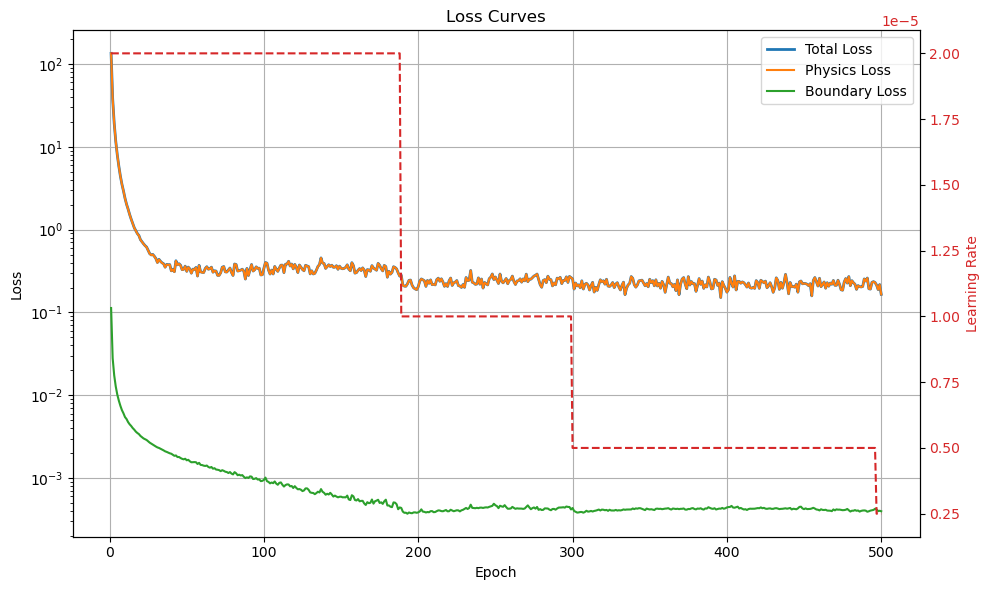

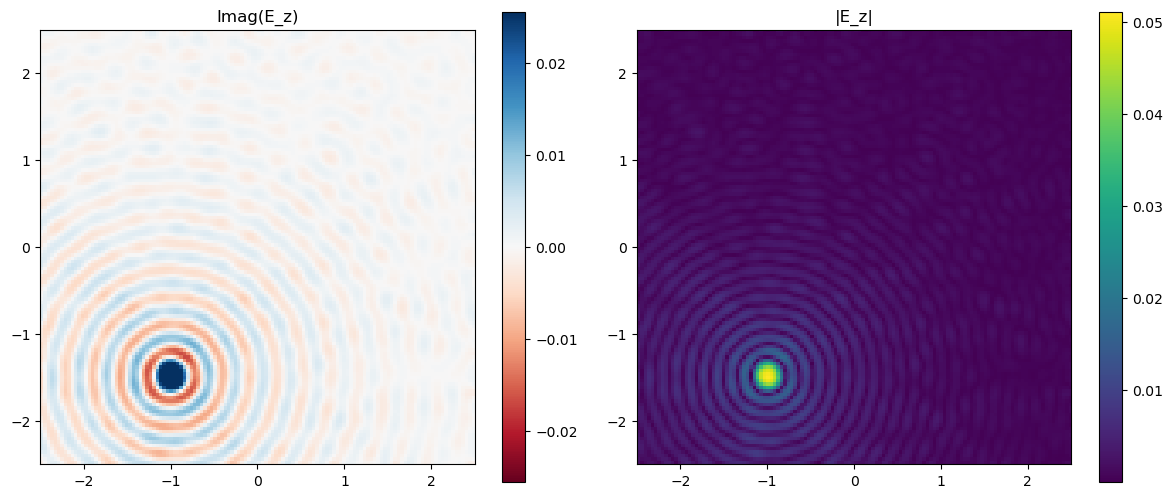

In [537]:

solver.plot_losses()
solver.predict()
solver.visualize()

We now place a **small dielectric circle** away from the center to test how the solver handles localized refractive index variations.


In [549]:
# ------------------------------
# Experiment 2: Small off-center dielectric circle
# ------------------------------
solver2 = HelmholtzSolver(params)

solver2.add_dielectric_circle(
    center=params['dielectric_center'],
    radius=params['dielectric_radius'],
    eps=params['dielectric_eps'],
)
solver2.train(num_epochs=params['num_epochs'], print_every=params['print_every'])


Training PINN:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch   50 | loss=3.9795e-01 | physics=3.9680e-01 | bc=1.1473e-03
Epoch  100 | loss=3.2798e-01 | physics=3.2733e-01 | bc=6.4765e-04
Epoch  150 | loss=3.6131e-01 | physics=3.6078e-01 | bc=5.2217e-04
Epoch  200 | loss=3.2601e-01 | physics=3.2565e-01 | bc=3.6116e-04
Epoch  250 | loss=2.8747e-01 | physics=2.8713e-01 | bc=3.4655e-04
Epoch  300 | loss=2.4158e-01 | physics=2.4136e-01 | bc=2.1782e-04
Epoch  350 | loss=2.4471e-01 | physics=2.4448e-01 | bc=2.2919e-04
Epoch  400 | loss=2.1092e-01 | physics=2.1076e-01 | bc=1.6301e-04
Epoch  450 | loss=2.2127e-01 | physics=2.2111e-01 | bc=1.5979e-04
Epoch  500 | loss=2.1793e-01 | physics=2.1772e-01 | bc=2.0425e-04


[89.40035486221313,
 26.077955067157745,
 12.636321395635605,
 7.826736107468605,
 5.3809684664011,
 3.9043068513274193,
 3.0587248131632805,
 2.418135091662407,
 2.002454698085785,
 1.7006031386554241,
 1.4487363770604134,
 1.2805442623794079,
 1.109887734055519,
 0.9982967432588339,
 0.9836506266146898,
 0.8391415998339653,
 0.8037983849644661,
 0.6936779506504536,
 0.7090474311262369,
 0.6189782004803419,
 0.5724045028910041,
 0.6369368815794587,
 0.5721228355541825,
 0.5657962393015623,
 0.45979853346943855,
 0.5687233693897724,
 0.5685839997604489,
 0.4820821788161993,
 0.3974198014475405,
 0.43268069066107273,
 0.4222798733972013,
 0.38592461543157697,
 0.4062256198376417,
 0.5173670868389308,
 0.42528406949713826,
 0.47107007075101137,
 0.38420536229386926,
 0.34097082540392876,
 0.39999073976650834,
 0.3856659084558487,
 0.381503916811198,
 0.4117532707750797,
 0.4290751591324806,
 0.3487177463248372,
 0.4218131313100457,
 0.44702922413125634,
 0.38944466738030314,
 0.311010987

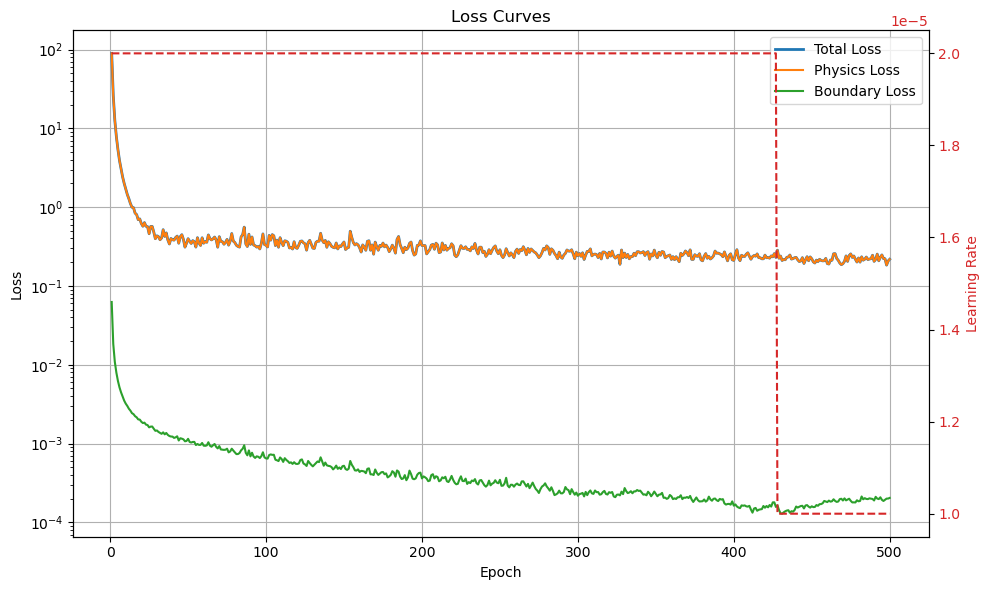

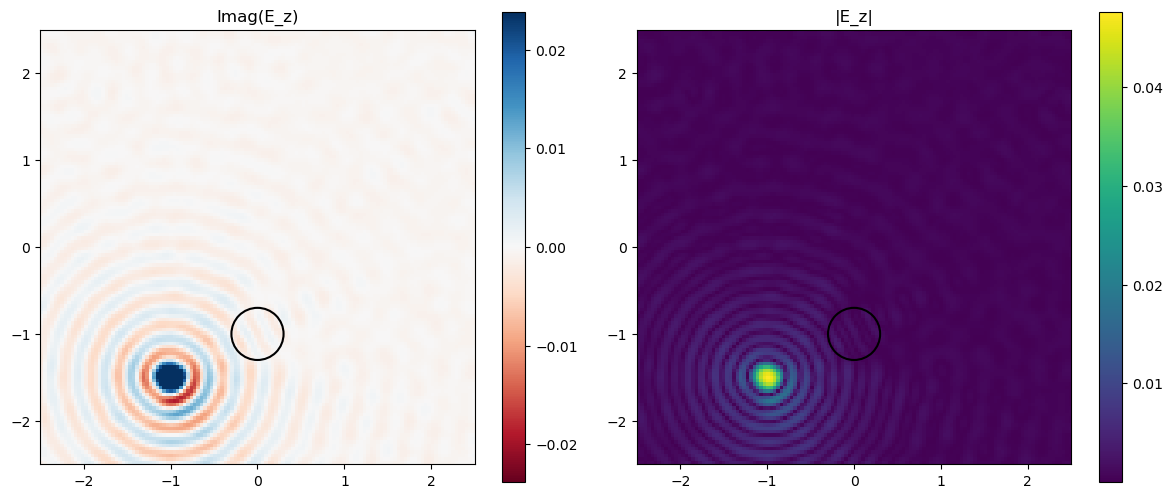

In [550]:
solver2.plot_losses()
solver2.predict()
solver2.visualize()

Here, we use a **large dielectric inclusion** at the grid center to observe strong scattering and field distortion effects.

Training PINN:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch   50 | loss=3.2778e-01 | physics=3.2598e-01 | bc=1.8016e-03
Epoch  100 | loss=2.8843e-01 | physics=2.8755e-01 | bc=8.7708e-04
Epoch  150 | loss=3.3744e-01 | physics=3.3691e-01 | bc=5.2718e-04
Epoch  200 | loss=2.2531e-01 | physics=2.2496e-01 | bc=3.4274e-04
Epoch  250 | loss=2.9736e-01 | physics=2.9700e-01 | bc=3.6253e-04
Epoch  300 | loss=1.8972e-01 | physics=1.8942e-01 | bc=3.0737e-04
Epoch  350 | loss=2.1941e-01 | physics=2.1906e-01 | bc=3.4598e-04
Epoch  400 | loss=2.0449e-01 | physics=2.0412e-01 | bc=3.6819e-04
Epoch  450 | loss=2.1415e-01 | physics=2.1377e-01 | bc=3.8498e-04
Epoch  500 | loss=2.0026e-01 | physics=1.9987e-01 | bc=3.9730e-04


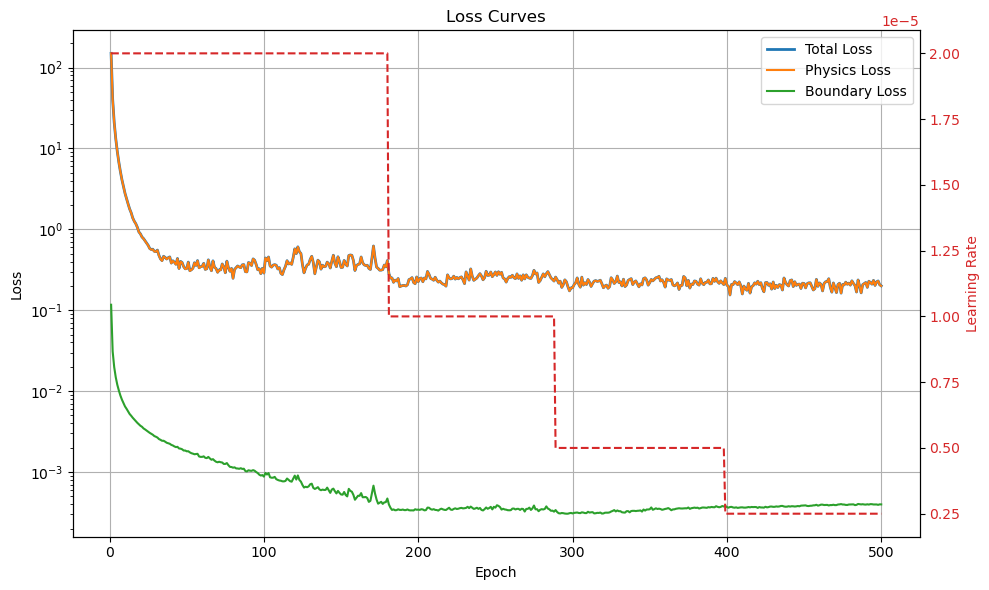

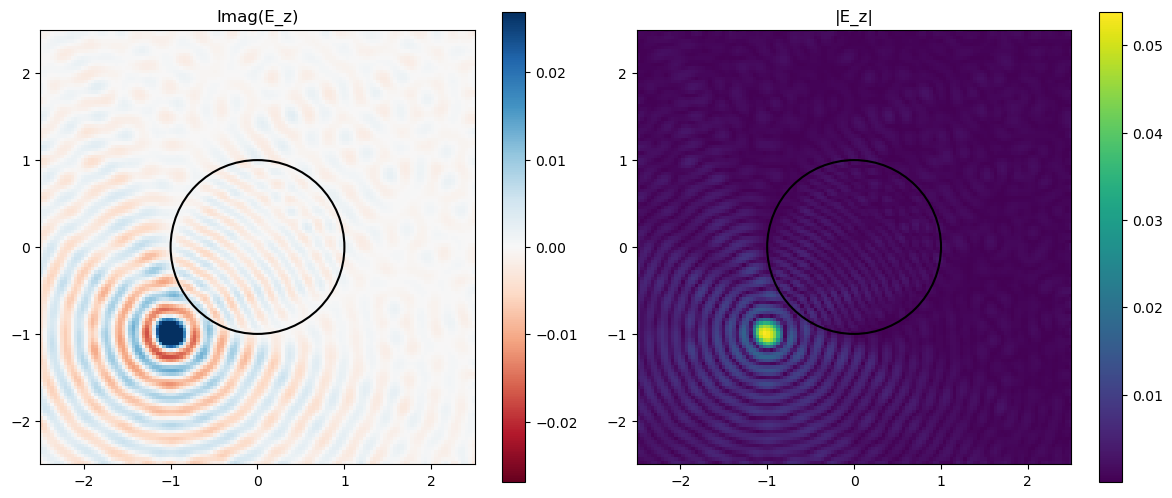

In [552]:
# ------------------------------
# Experiment 3: Large dielectric circle in the grid center
# ------------------------------
params3 = {
    # domain parameters
    'domain_size': 5.0,  # size of the domain
    'grid_points': 128,

    # Physics parameters
    'omega': 20.0,
    'source_position': (-1.0, -1.0),

    # Dielectric parameters
    'has_dielectric': True,
    'dielectric_center': (0.0, 0.0),
    'dielectric_radius': 1.0,
    'dielectric_eps': 2.0,

    # Network parameters
    'hidden_features': 256,
    'hidden_layers': 3,
    'omega_0': 30,

    # Training parameters,
    'num_epochs': 500,
    'learning_rate': 2e-5,
    'batch_size': 512,
    'print_every': 50,

    # Scheduler parameters
    'use_scheduler': True,
    'scheduler_patience': 100,
    'scheduler_factor': 0.5,
    'scheduler_min_lr': 1e-9,
}
solver3 = HelmholtzSolver(params3)
if params3['has_dielectric']:
    solver3.add_dielectric_circle(
        center=params3['dielectric_center'],
        radius=params3['dielectric_radius'],
        eps=params3['dielectric_eps'],
    )
solver3.train(num_epochs=params3['num_epochs'], print_every=params3['print_every'])


solver3.plot_losses()
solver3.predict()
solver3.visualize()

**Additional observations for this case:**
In this run, the scattered wavefront rings aren’t as perfectly concentric as in the free-space example - you can see small distortions creeping in. The training curves back this up: the physics loss levels off quite early, and toward the end there’s a bit of fluctuation, with the boundary loss even ticking upward after about 500 epochs.

This suggests the model hasn’t fully converged yet. A bit of fine-tuning could help - for example, running more epochs with a gentler learning rate decay, tweaking $\omega_0$ to better capture fine details, or making the absorbing boundary a little larger or smoother to cut down on edge reflections. These adjustments would likely clean up the wavefront and give a more polished final result.


## Conclusions

The 2D Helmholtz PINN with SIREN successfully reproduced physically consistent wave patterns for all tested scenarios, confirming the method’s ability to capture both free-space propagation and scattering in dielectric environments.

**Key outcomes:**
- **Accuracy & Physical Consistency:**
  In free space, the PINN maintained radial symmetry, correct phase advance, and expected $|E_z|$ decay.
  In dielectric cases, wavefront bending, wavelength shortening, and interference patterns aligned with analytical expectations.
- **Model Sensitivity:**
  Localized scattering from small inclusions was correctly confined to the shadow region, while large central dielectrics produced significant wavefront distortion and mild focusing.
- **Training Behavior:**
  Total and physics losses converged rapidly, with boundary loss showing slower decay, especially for complex geometries.
  A moderate SIREN frequency factor ($\omega_0 = 30$) balanced the ability to capture high-frequency features with training stability.

**Practical insights:**
- The current absorbing boundary is adequate for qualitative studies, but switching to a PML or impedance-matched layer would reduce residual reflections.
- The point source model works but could be improved with a smoothed Gaussian source to better match continuous-wave physics.
- Multiple inclusions and more intricate refractive index profiles can be implemented without major code changes, making the framework extensible.

**Overall conclusion:**
This work demonstrates that a compact, well-tuned PINN+SIREN architecture can qualitatively replicate expected Helmholtz solutions with good physical fidelity, even in the presence of refractive structures. The approach is modular, reproducible, and easily extendable for more complex scattering problems. For high-accuracy quantitative studies, future improvements should focus on advanced source modeling, better absorbing boundaries, and higher-resolution training with GPU acceleration.